In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from utils import *
from plots import *
import warnings
import dal
from tqdm import tqdm
warnings.filterwarnings("ignore")
from models import Network, Hypergraph, BipartateNetwork, EigenValueCentrality
from experiment_models import Experiment, SpreadingPhenomena

In [3]:
snow_runner = dal.SnowflakeRunner()

## Communication Network

In [4]:
dict_cursor = snow_runner.get_data_raw('queries/conversations_private.sql')
dict_cursor_roles = snow_runner.get_data_raw('queries/user_roles.sql')

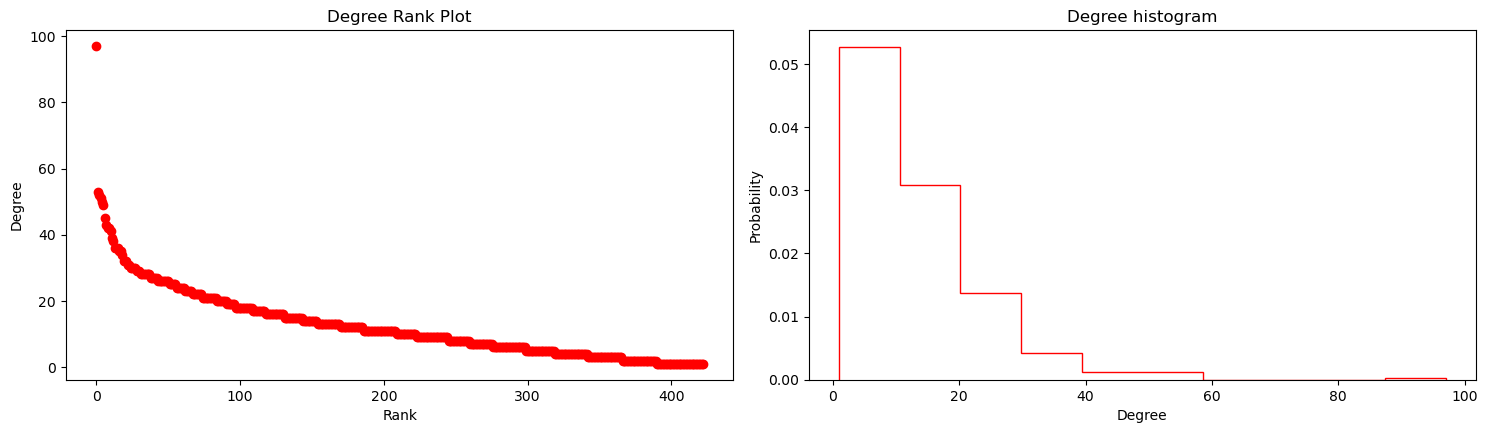

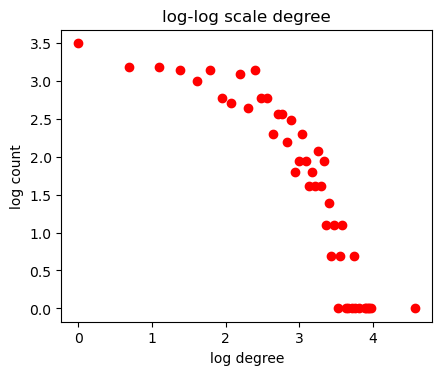

In [6]:
network = Network(
    name='conversations_private',
    description='Private conversations between users',
    node_attributes=dict_cursor_roles,
    data=dict_cursor
)

network._network()
network.compute_metrics()

untouched_network = network.G.copy()

In [7]:
len(network.G.edges)

2689

In [8]:
print(nx.adjacency_matrix(network.G))

  (0, 0)	1
  (0, 189)	1
  (0, 192)	1
  (0, 220)	1
  (1, 1)	15
  (1, 20)	6
  (1, 40)	9
  (1, 68)	6
  (1, 127)	3
  (1, 187)	6
  (1, 258)	3
  (1, 404)	7
  (2, 42)	3
  (2, 47)	3
  (2, 249)	6
  (3, 19)	3
  (3, 49)	7
  (3, 154)	5
  (3, 158)	4
  (3, 257)	17
  (3, 342)	9
  (3, 382)	18
  (3, 393)	8
  (3, 410)	7
  (4, 69)	4
  :	:
  (422, 46)	4
  (422, 47)	6
  (422, 92)	4
  (422, 112)	8
  (422, 113)	12
  (422, 132)	4
  (422, 135)	3
  (422, 143)	20
  (422, 182)	3
  (422, 216)	3
  (422, 217)	5
  (422, 257)	5
  (422, 265)	5
  (422, 295)	12
  (422, 302)	10
  (422, 305)	3
  (422, 314)	4
  (422, 321)	5
  (422, 327)	6
  (422, 330)	3
  (422, 342)	9
  (422, 356)	8
  (422, 362)	6
  (422, 384)	10
  (422, 418)	30


## Avg. Clustering

In [9]:
network.average_clustering

0.011137873781494051

## Small World?

In [10]:
closeness_centrality = sorted(network.closeness_centrality.values(), reverse=True)

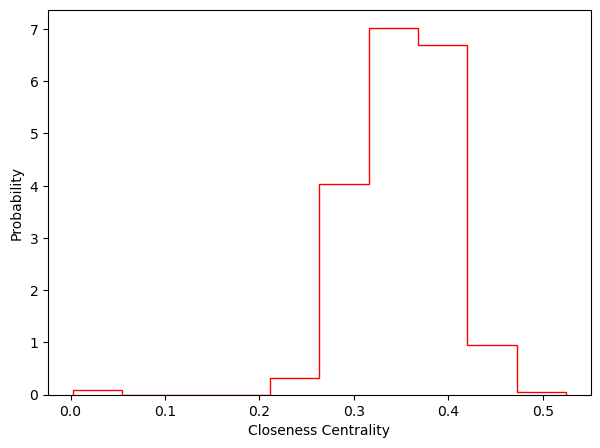

In [11]:
plot_histograms(closeness_centrality, 'Closeness Centrality', 'closeness_centrality')

In [12]:
network.average_shortest_path_length

[(2.869664065151001, 421), (1.0, 2)]

## Models

In [30]:
BANet = nx.barabasi_albert_graph(n=len(network.G.nodes), m=int(round(len(network.G.edges)/len(network.G.nodes), 0)))

In [14]:
degree = sorted([d for n, d in BANet.degree()], reverse=True)

In [32]:
len(BANet.edges)

2202

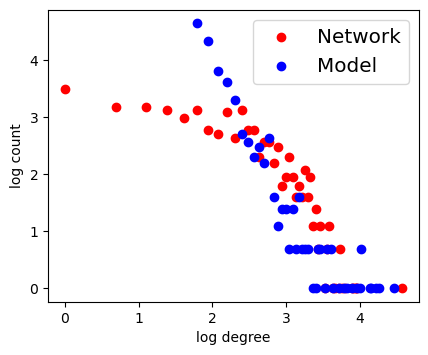

In [15]:
compare_log_log_plots(network.degree_sequence, degree)

As we can see in the graph above, our network, after certain degree, it follows a power law. The fact that it initially follows a a differet type of distribution, indicates that there are several nodes with low degree.

In [16]:
general_network = Experiment(
    name='general_network',
    network=network
)
general_network.network.G = untouched_network.copy()

random_removal_general_network = []

for i in tqdm(range(50)):
    general_network.nodes_to_remove(1, random=True)
    general_network.remove_nodes()
    general_network.compute_metrics()
    random_removal_general_network.append(general_network.network.largest_component)

100%|██████████| 50/50 [03:01<00:00,  3.63s/it]


In [17]:
def line_plot(data, title, xlabel, ylabel):
    plt.plot(data,
            label='title', 
            color='red', 
            linestyle='dashed',
            marker='o',
            markerfacecolor='blue',
            markersize=5,
            linewidth=2,
            alpha=0.7
            )
    plt.ylim(0.9, 1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

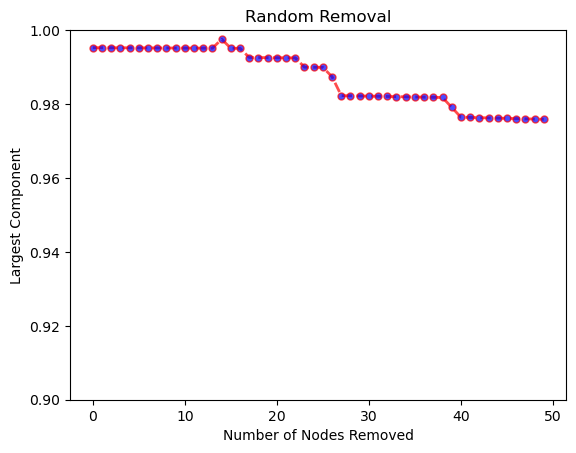

In [18]:
line_plot(random_removal_general_network,
          'Random Removal',
          'Number of Nodes Removed',
          'Largest Component')

In [19]:
from tqdm import tqdm
general_network = Experiment(
    name='general_network',
    network=network.copy()
)
general_network.compute_metrics()
general_network.network.G = untouched_network.copy()
ordered_removal_general_network = []

for i in tqdm(range(50)):
    general_network.nodes_to_remove(1, random=False)
    general_network.remove_nodes()
    general_network.compute_metrics()
    ordered_removal_general_network.append(general_network.network.largest_component)

100%|██████████| 50/50 [02:30<00:00,  3.02s/it]


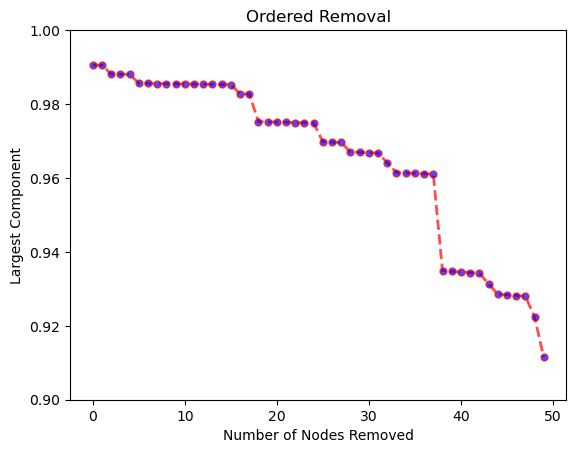

In [20]:
line_plot(ordered_removal_general_network,
          'Ordered Removal',
          'Number of Nodes Removed',
          'Largest Component')

## 20% of the workforce

In [52]:
n = int(round(len(network.G.nodes()) * 0.1, 0))

In [53]:
general_network = Experiment(
    name='general_network',
    network=network.copy()
)
general_network.network.G = untouched_network.copy()
general_network.compute_metrics()

In [54]:
resutls = []
#resutls.append(general_network.network.initial_connected_components)

for i in tqdm(range(1000)):
    general_network.nodes_to_remove(n, random=True)
    r_betweeness_centrality = list(
        dict(
            filter(lambda x: x[0] in general_network.removed_nodes, general_network.network.betweenness_centrality.items())
            ).values()
    )
    r_closeness_centrality = list(
        dict(
            filter(lambda x: x[0] in general_network.removed_nodes, general_network.network.closeness_centrality.items())
            ).values()
    )
    r_eigenvector_centrality = list(
        dict(
            filter(lambda x: x[0] in general_network.removed_nodes, general_network.network.eigenvector_centrality.items())
            ).values()
    )
    r_degree_centrality = list(
        dict(
            filter(lambda x: x[0] in general_network.removed_nodes, dict(general_network.network.degree_centrality).items())
            ).values()
    )
    r_clustering = list(
        dict(
            filter(lambda x: x[0] in general_network.removed_nodes, general_network.network.clustering.items())
            ).values()
    )
    general_network.remove_nodes()
    general_network.compute_metrics()
    metrics = dict(
                    c_betweeness_centrality = np.median(r_betweeness_centrality),
                    c_closeness_centrality = np.median(r_closeness_centrality),
                    c_eigenvector_centrality = np.median(r_eigenvector_centrality),
                    c_degree_centrality = np.median(r_degree_centrality),
                    c_clustering = np.median(r_clustering),
                    c_average_clustering = general_network.network.average_clustering,
                    c_average_shortest_path_length = general_network.network.average_shortest_path_length[0][0],
                    n_connected_components = general_network.network.largest_component
                )
    resutls.append(metrics)
    general_network.network.G = untouched_network.copy()
    general_network.compute_metrics()

100%|██████████| 1000/1000 [1:27:33<00:00,  5.25s/it]


In [55]:
import pandas as pd

df = pd.DataFrame(resutls)

df.to_csv('../csvs/general_network.csv', index=False)

## Spreading Phenomena

In [21]:
spreading = SpreadingPhenomena(
    name='general_network',
    network=network.copy()
)
spreading.network.G = untouched_network.copy()
spreading.initialize()

rates = []

for i in tqdm(range(20)):
    spreading.spreading()
    rates.append(spreading.rate_of_spread)


100%|██████████| 20/20 [00:00<00:00, 1018.22it/s]


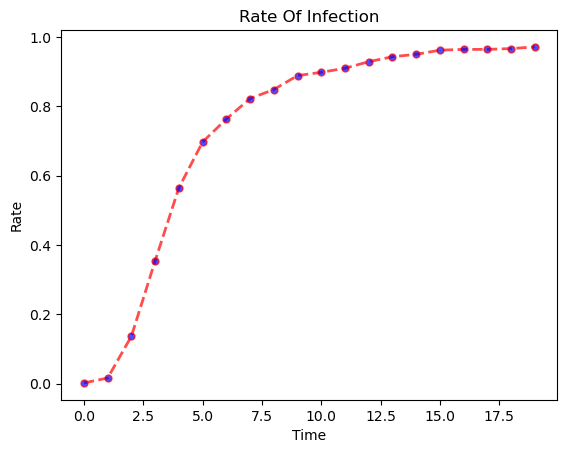

In [22]:
line_plot(rates,'Rate Of Infection', 'Time', 'Rate')

In [23]:
spreading = SpreadingPhenomena(
    name='general_network',
    network=network.copy()
)
spreading.network.G = untouched_network.copy()
spreading.initialize()

time_to_complete = []
nodes_removed = [5 * i for i in range(13)]
for i in tqdm(range(13)):
    n = 5 * i
    spreading.nodes_to_remove(n, random=True)

    while spreading.rate_of_spread < 0.99:
        spreading.spreading()
        
    time_to_complete.append(spreading.timesatmp)
    spreading.remove_nodes()

100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


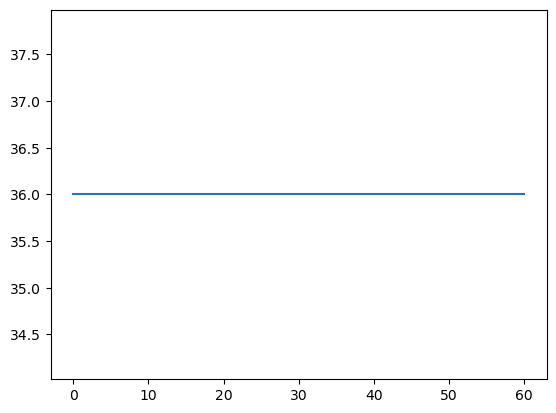

In [25]:
plt.plot(nodes_removed, time_to_complete)

## Bipartate Network

For this part, we analyse it the network as a bipartate graph because this architecture offeres a very intuitive way of approaching the problem. We have users, and these users can pertain to different channels.



Judging by the degree distributions, the allocation of memebers to channels seems to be random. Scpecially, if we look at the log-log degree plot, it resambles that of a binomial distribution. To farther assure that this is infact a random distribution, let's run a model of a random graph and compare the results.

In [9]:
dict_cursor_b = snow_runner.get_data_raw('queries/conversation_members.sql')

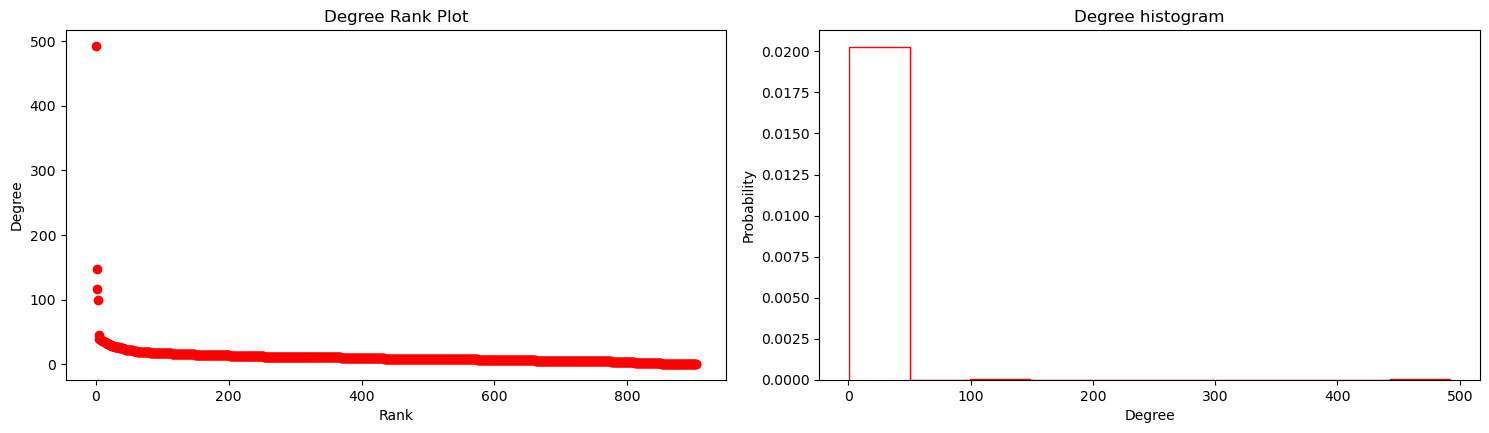

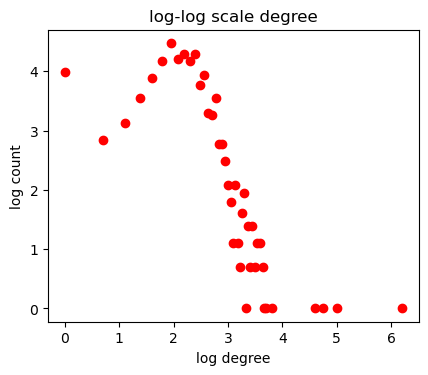

In [10]:
BNetwork = BipartateNetwork(
    name='conversation_members',
    description='Private channels between users',
    data=dict_cursor_b
)
BNetwork._network()
BNetwork.compute_metrics()

untouched_network_b = BNetwork.G.copy()


In a random network, the probability that it has L liks is the product of three terms.

$$
p_L = \binom{\frac{N(N-1)}{2}}{L}p^L(1-p)^{\frac{N(N-1)}{2} - L}

$$

The expacted number of links of a random graph is:

$$

L = \sum_{L=0}^{\frac{N(N-1)}{2}} L_{p_L} = p\frac{N(N-1)}{2}

$$

We do know L from our original graph, and we do know N, so lets calculate p


In [32]:
p = 5063/((905*904)/2)

#### Now, lets generate a random graph

In [12]:
RN = nx.erdos_renyi_graph(905, p, seed=None, directed=False)

In [13]:
degree = sorted([d for n, d in RN.degree()], reverse=True)

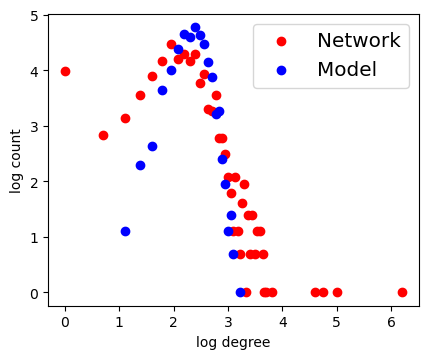

In [14]:
import utils
compare_log_log_plots(BNetwork.degree_sequence, degree)

As we can see in the plot above, in fact, the degree distribution of the random network is very similar to that of our real network.

What does this mean?

It means that in our network, regarding public channels, our users are randomly distributed among channels.

This is an indicator that every one in the network has equal access to the companies public information. Remember that we are just analysing the precence of a member in a given channel, not their interactions inside the given channel. That will come in the next session.

As we can see in the following plots, except some outliers (probably bots). We observe that they are normaly distributtd?

#### Random Attacks Of the Channels

One way we can evaluate the well information flows through a given network is the number of connected componnents. The higher it is, the more disconneced the network. The lower it is the more connected the network.

In this section we will see how much we disturb our network if we were to eliminate channels. First randomly and then a planned attack based on the degree of the channel.

In [31]:
len(BNetwork.G.edges)

5063

In [35]:
channels = list(BNetwork.G)[:383]

bipartate_network = Experiment(
    name='bipartate_network',
    network=BNetwork.copy()
)
bipartate_network.network.G = untouched_network_b.copy()
bipartate_network.compute_metrics()

In [ ]:
random_removal_bipartate = []
random_removal_bipartate.append(bipartate_network.network.initial_largest_component)

for i in tqdm(range(50)):
    channel = np.random.choice(channels, 1, replace=False)[0]
    channels.remove(channel)
    bipartate_network.remove_nodes([channel])
    bipartate_network.compute_metrics()
    random_removal_bipartate.append(bipartate_network.network.largest_component)

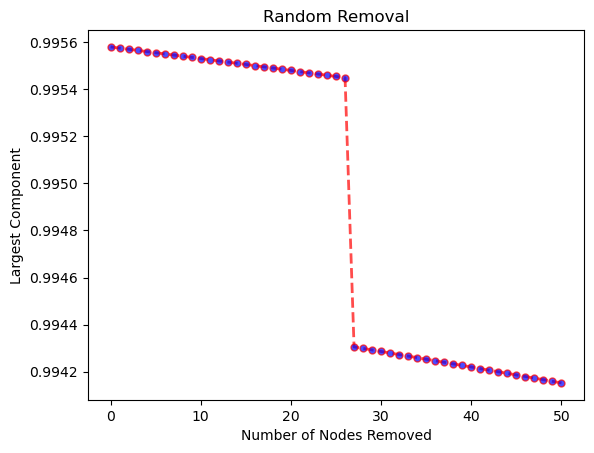

In [ ]:
line_plot(random_removal_bipartate, 'Random Removal', 'Number of Nodes Removed', 'Largest Component')

In [35]:
bipartate_network = Experiment(
    name='bipartate_network',
    network=BNetwork.copy()
)

bipartate_network.network.G = untouched_network_b.copy()

bipartate_network.compute_metrics()

filtered_dict = {k:v for k,v in bipartate_network.ordered_degree.items() if 'C' == k[0]}
channels = list(filtered_dict.keys())

In [36]:
ordered_removal_bipartate = []
ordered_removal_bipartate.append(bipartate_network.network.initial_largest_component)

for channel in tqdm(channels[:50]):
    bipartate_network.remove_nodes([channel])
    bipartate_network.compute_metrics()
    ordered_removal_bipartate.append(bipartate_network.network.largest_component)

100%|██████████| 50/50 [03:54<00:00,  4.69s/it]


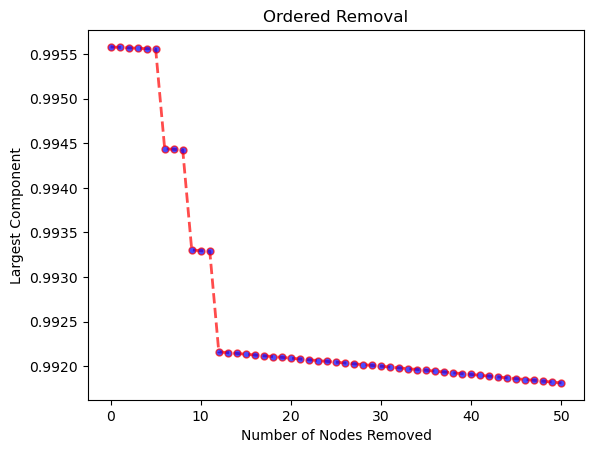

In [37]:
line_plot(ordered_removal_bipartate, 'Ordered Removal', 'Number of Nodes Removed', 'Largest Component')

When an attack is planned, just by removing the first channel, the network becomes highly fragmented

## HyperGraph

In [5]:
dict_cursor_project = snow_runner.get_data_raw('queries/project_members.sql')

### Projects Delivered On Time

In [6]:
cursor_on_time = [i for i in filter(lambda x: x['ON_TIME'] == True, dict_cursor_project)]

In [7]:
H_ontime = Hypergraph(
    name='on_time',
    description='Private channels between users',
    node_attributes=dict_cursor_roles,
    data=cursor_on_time
)

H_ontime._network()

In [8]:
print(f"The Hypergraph has {len(H_ontime.G.nodes)} nodes and {len(H_ontime.G.edges)} edges")

The Hypergraph has 639 nodes and 673 edges


In [18]:
# This class computes the eigenvector centrality of each node in the network
import scipy

class eigen_value_centrality:
    def __init__(self, G):
        self.G = G
        self.eigen_centrality = None
        self.eig_vals = None
        self.eig_vecs = None
        self.click_matrix = None
        self.nodes = np.array(self.G.nodes)
        self.cpms = list(G.nodes.filterby_attr('position', 'PROJECTMANAGER'))
        self.eigen_centrality_cpms = None
    def largest_component(self):
        largest_component = [i for i in xgi.connected_components(self.G)][0]
        self.G = xgi.subhypergraph(self.G, largest_component)
    def get_click_matrix(self):
        self.click_matrix = xgi.clique_motif_matrix(self.G).todense()
    def compute_eigen_vs(self):
        self.eig_vals, self.eig_vecs = scipy.linalg.eig(self.click_matrix)
    def compute_eigen_centrality(self):
        largest_eigval = np.argmax(self.eig_vals)
        self.eigen_centrality = abs(self.eig_vecs[:,largest_eigval])
    def compute(self):
        self.largest_component()
        self.get_click_matrix()
        self.compute_eigen_vs()
        self.compute_eigen_centrality()
        self.eigen_centrality = dict(zip(self.nodes, self.eigen_centrality))
        self.eigen_centrality_cpms = {k:v for k,v in self.eigen_centrality.items() if k in self.cpms}



In [17]:
eigen_value_centrality = eigen_value_centrality(H_ontime.G)
eigen_value_centrality.compute()
ontime_eigen_centrality = eigen_value_centrality.eigen_centrality
ontime_eigen_centrality_cpms = eigen_value_centrality.eigen_centrality_cpms

del ontime_eigen_centrality_cpms['ULSRA0WSC']
del ontime_eigen_centrality['ULSRA0WSC']

### Projects Not In Time

In [11]:
cursor_out_time = [i for i in filter(lambda x: x['ON_TIME'] == False, dict_cursor_project)]

In [13]:
#cursor_out_time = list(np.random.choice(cursor_out_time, 673, replace=False))

In [14]:
H_outtime = Hypergraph(
    name='out_of_time',
    description='Private channels between users',
    node_attributes=dict_cursor_roles,
    data=cursor_out_time
)

H_outtime._network()

In [23]:
print(f"The Hypergraph has {len(H_outtime.G.nodes)} nodes and {len(H_outtime.G.edges)} edges")

The Hypergraph has 641 nodes and 3680 edges


In [19]:
eigen_value_centrality = eigen_value_centrality(H_outtime.G)
eigen_value_centrality.compute()
outtime_eigen_centrality = eigen_value_centrality.eigen_centrality
outtime_eigen_centrality_cpms = eigen_value_centrality.eigen_centrality_cpms

del outtime_eigen_centrality_cpms['ULSRA0WSC']
del outtime_eigen_centrality['ULSRA0WSC']

### Comparison

According to this Data, in the "Out Of Time" Graph, the participation of the CPMs in projects seems to be Higher

In [20]:
def compare_histograms(scores1:np.ndarray,
                       scores2:np.ndarray,
                       title:str,
                       label1:str = None,
                       label2:str = None) -> None:

    fig, ax = plt.subplots()
    ax.hist(scores1, histtype='step', label=label1, density=True, color='red')
    ax.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.legend(loc='upper right')
    plt.show()

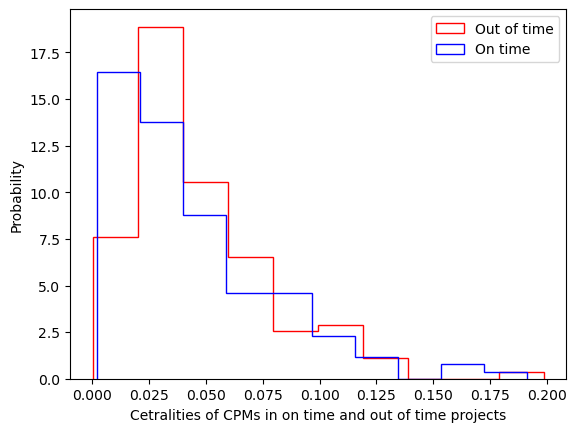

In [32]:
out_of_time = [v for k,v in outtime_eigen_centrality_cpms.items()]
on_time = [v for k,v in ontime_eigen_centrality_cpms.items()]

compare_histograms(
    out_of_time,
    on_time,
    "Cetralities of CPMs in on time and out of time projects",
    "Out of time",
    "On time")

In [31]:
ks_sample_test(out_of_time, on_time)

0.39628647286191016

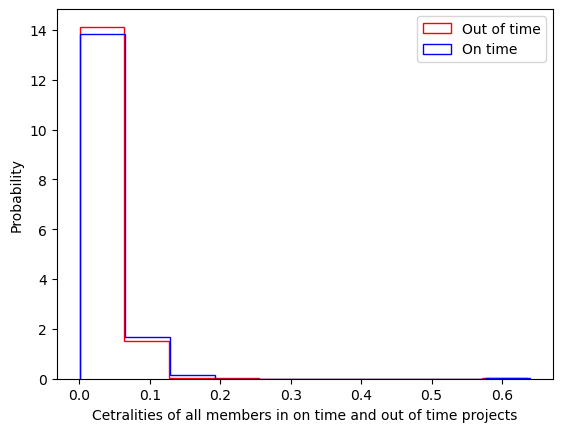

In [33]:
out_of_time = [v for k,v in outtime_eigen_centrality.items()]
on_time = [v for k,v in ontime_eigen_centrality.items()]

compare_histograms(
    out_of_time,
    on_time,
    "Cetralities of all members in on time and out of time projects",
    "Out of time",
    "On time")

In [34]:
ks_sample_test(out_of_time, on_time)

0.39628647286191016